# IMPORTS

In [32]:
##################
# IMPORT MODULES #
##################
# SYS IMPORT
import os, inspect, importlib, argparse
import random
import gc
import time
import pandas as pd
import numpy as np
from pathlib import Path

from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
import lightgbm as lgb 
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score, mean_squared_error
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# UTILS

In [2]:
def seed_everything(seed):
    """
    Seeds basic parameters for reproductibility of results
    
    Arguments:
        seed {int} -- Number of the seed
    """
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)

seed_everything(95)

# CONFIG

In [3]:
config = {
    "DATA_PATH" : "D:/Documents/GitHub/ml-pipeline/data/TPS-MAR2021/train.csv",
    "TARGET_VAR" : "target"
}

# DATA & FEATURE ENGINEERING

In [4]:
df = pd.read_csv(config["DATA_PATH"])
target = df[config["TARGET_VAR"]]
df.head()

,id,cat0,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,...,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,target
0,0,A,I,A,B,B,BI,A,S,Q,...,0.759439,0.795549,0.681917,0.621672,0.592184,0.791921,0.815254,0.965006,0.665915,0
1,1,A,I,A,A,E,BI,K,W,AD,...,0.386385,0.541366,0.388982,0.357778,0.600044,0.408701,0.399353,0.927406,0.493729,0
2,2,A,K,A,A,E,BI,A,E,BM,...,0.343255,0.616352,0.793687,0.552877,0.352113,0.388835,0.412303,0.292696,0.549452,0
3,3,A,K,A,C,E,BI,A,Y,AD,...,0.831147,0.807807,0.800032,0.619147,0.221789,0.897617,0.633669,0.760318,0.934242,0
4,4,A,I,G,B,E,BI,C,G,Q,...,0.338818,0.277308,0.610578,0.128291,0.578764,0.279167,0.351103,0.357084,0.328960,1


In [5]:
def cat_encoding(dataframe):
    cat = dataframe.columns[1:20]
    for feature in cat:
        le = LabelEncoder()
        le.fit(dataframe[feature])
        dataframe[feature] = le.transform(dataframe[feature])
    return dataframe

def feature_engineering(dataframe):
    dataframe = cat_encoding(dataframe)
    features = dataframe.columns[1:31]
    return dataframe, features

In [6]:
df, features = feature_engineering(df)
df.head()

,id,cat0,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,...,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,target
0,0,0,8,0,1,1,33,0,44,54,...,0.759439,0.795549,0.681917,0.621672,0.592184,0.791921,0.815254,0.965006,0.665915,0
1,1,0,8,0,0,4,33,8,48,3,...,0.386385,0.541366,0.388982,0.357778,0.600044,0.408701,0.399353,0.927406,0.493729,0
2,2,0,10,0,0,4,33,0,30,38,...,0.343255,0.616352,0.793687,0.552877,0.352113,0.388835,0.412303,0.292696,0.549452,0
3,3,0,10,0,2,4,33,0,50,3,...,0.831147,0.807807,0.800032,0.619147,0.221789,0.897617,0.633669,0.760318,0.934242,0
4,4,0,8,6,1,4,33,2,32,54,...,0.338818,0.277308,0.610578,0.128291,0.578764,0.279167,0.351103,0.357084,0.328960,1


In [7]:
df[features].head()

,cat0,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,...,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10
0,0,8,0,1,1,33,0,44,54,0,...,0.855349,0.759439,0.795549,0.681917,0.621672,0.592184,0.791921,0.815254,0.965006,0.665915
1,0,8,0,0,4,33,8,48,3,5,...,0.328929,0.386385,0.541366,0.388982,0.357778,0.600044,0.408701,0.399353,0.927406,0.493729
2,0,10,0,0,4,33,0,30,38,9,...,0.322749,0.343255,0.616352,0.793687,0.552877,0.352113,0.388835,0.412303,0.292696,0.549452
3,0,10,0,2,4,33,0,50,3,5,...,0.707663,0.831147,0.807807,0.800032,0.619147,0.221789,0.897617,0.633669,0.760318,0.934242
4,0,8,6,1,4,33,2,32,54,0,...,0.274514,0.338818,0.277308,0.610578,0.128291,0.578764,0.279167,0.351103,0.357084,0.328960


## SPLIT TRAIN AND VALID SETS

In [8]:
train_x, valid_x, train_y, valid_y = train_test_split(df[features], target, test_size=0.2, random_state=95)

## METRIC

In [9]:
auc = roc_auc_score

# SELECT MODEL & CALCULATE METRICS

## MODEL PARAMETERS

In [10]:
LOGIT_parameters = {
    "max_iter" : 10000,
    "random_state"  : 95,
}

RF_parameters = {
    "max_depth" : 15, 
    "min_samples_split" : 7, 
    "min_samples_leaf" : 5,
    "max_features" : 25,
    "n_estimators" : 1000,
    "n_jobs" : -1,
    "random_state" : 95
}

LGBM_parameters = {
    'objective': 'binary',
    'metric' : 'auc',
    'n_estimators' : 1000,
    'random_state' : 95,
    'cat_smooth' : 30,
    'reg_alpha': 0.0031293275223408185,
    'reg_lambda': 0.04787145507141445,
    'colsample_bytree': 0.3,
    'subsample': 0.6,
    'learning_rate': 0.008,
    'max_depth': 100,
    'num_leaves': 584,
    'min_child_samples': 173
}

XGB_parameters = {
    "objective": "binary:logistic",
    "eval_metric" : "auc",
    "seed": 95,
    'tree_method': "gpu_hist",
    'predictor': 'gpu_predictor',
    'use_label_encoder' : False,
    "n_estimators" : 1000,
    'max_bin' : 64,
    "max_depth": 12, #Max should correspond to max number of features (probably ?),
    'alpha' : 11.607239831188968,
    'gamma' : 2.1593805822598444,
    "learning_rate": 0.02,
    "colsample_bytree": 0.8016656211574054,
    "subsample": 0.983461992112787,
    "reg_alpha" : 1.7306711078859136,
    "min_child_weight": 9.417969426623086,
    "n_jobs": 2
}

In [11]:
model_dict = {
    "LogisticRegression" : LogisticRegression(**LOGIT_parameters),
    "RFClassifier" : RandomForestClassifier(**RF_parameters),
    "LGBMClassifier" : lgb.LGBMClassifier(**LGBM_parameters),
    "XGBClassifier" : xgb.XGBClassifier(**XGB_parameters)
}

In [29]:
def compare_models(models, X_train, y_train, X_valid, y_valid, metric):
    scores = pd.DataFrame(columns = ['score', 'model'])
    for name, model in models.items():
        start = time.perf_counter()
        print(f"Training model : {name}")
        model.fit(X_train, y_train)
        preds = model.predict_proba(X_valid)[:, 1]
        score = metric(y_valid, preds)
        end = time.perf_counter()
        print(f"Validation score : {score} in {end - start:0.4f} seconds")
        scores = scores.append({'score' : score, "model" : name}, ignore_index = True)      
    return scores

In [33]:
scores = compare_models(model_dict, train_x, train_y, valid_x, valid_y, auc)

Training model : LogisticRegression
Validation score : 0.8669340991227449 in 26.8914 seconds
Training model : RFClassifier
Validation score : 0.8814595033060593 in 631.9698 seconds
Training model : LGBMClassifier
Validation score : 0.8943482300205073 in 48.4252 seconds
Training model : XGBClassifier
Validation score : 0.8913716198650015 in 38.3783 seconds


In [34]:
scores.head()

,score,model
0,0.866934,LogisticRegression
1,0.881460,RFClassifier
2,0.894348,LGBMClassifier
3,0.891372,XGBClassifier


# AND THE WINNER IS ....

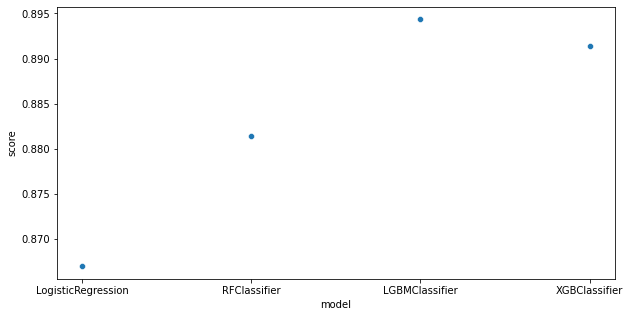

In [35]:
plt.figure(figsize = (10,5))
sns.scatterplot(data = scores, x = 'model', y = 'score')
plt.show()